In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

In [2]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv'
url = 'https://www.kaggle.com/code/shahraizanwar/age-gender-ethnicity-prediction/data?select=age_gender.csv'

In [3]:
data = pd.read_csv(data_path)

In [ ]:
data.columns

# Loading data from google cloud to google colab

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/age_gender.csv')

 # Transforming the pixels data type into a list of float

In [ ]:
# images =[]
# for fotos in range(len(data['pixels'])):
#     X = data['pixels'][fotos].split(" ")
#     X = list(map(int, X))
#     images.append(X)

In [ ]:
# x = np.reshape(images[5000], (48,48))

In [4]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [5]:
blob = data['pixels'][0].reshape(48,48)

In [ ]:
plt.imshow(blob, cmap='gray');

In [ ]:
#sns.displot(data['ethnicity']),
#sns.displot(data['gender']), 
#sns.displot(data['age']);
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(ax=axes[0], x=data['age']);
sns.histplot(ax=axes[1], x=data['ethnicity']);
sns.histplot(ax=axes[2], x=data['gender']);

# Working with the age

In [ ]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))

In [ ]:
# table with the first 15 most dense samples regarding age
type(ages), type(counts)
s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
s=s.transpose()
more_dense = s.sort_values(by=['counts'], ascending=False)
more_dense.head(15)

In [ ]:
data = data.drop(data[data.age==29].index).copy()
data.reset_index(drop=True)

In [ ]:
sns.histplot(data.age);

The filter of Pierre

In [6]:
data_clean = data.copy()
data['points_bin'] = pd.qcut(data_clean['age'], q=10)

#view updated DataFrame
print(data)
data['points_bin'].value_counts()

       age  ethnicity  gender                        img_name  \
0        1          2       0  20161219203650636.jpg.chip.jpg   
1        1          2       0  20161219222752047.jpg.chip.jpg   
2        1          2       0  20161219222832191.jpg.chip.jpg   
3        1          2       0  20161220144911423.jpg.chip.jpg   
4        1          2       0  20161220144914327.jpg.chip.jpg   
...    ...        ...     ...                             ...   
23700   99          0       1  20170120221920654.jpg.chip.jpg   
23701   99          1       1  20170120134639935.jpg.chip.jpg   
23702   99          2       1  20170110182418864.jpg.chip.jpg   
23703   99          2       1  20170117195405372.jpg.chip.jpg   
23704   99          0       1  20170110182052119.jpg.chip.jpg   

                                                  pixels     points_bin  
0      [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...   (0.999, 6.0]  
1      [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....   (0.999, 6.0]

(34.0, 40.0]     2772
(20.0, 25.0]     2760
(0.999, 6.0]     2494
(6.0, 20.0]      2383
(50.0, 61.0]     2370
(29.0, 34.0]     2290
(61.0, 116.0]    2236
(25.0, 26.0]     2197
(26.0, 29.0]     2103
(40.0, 50.0]     2100
Name: points_bin, dtype: int64

In [7]:
data

,age,ethnicity,gender,img_name,pixels,points_bin
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...","(0.999, 6.0]"
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....","(0.999, 6.0]"
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79....","(0.999, 6.0]"
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202...","(0.999, 6.0]"
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210...","(0.999, 6.0]"
...,...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,"[127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9...","(61.0, 116.0]"
23701,99,1,1,20170120134639935.jpg.chip.jpg,"[23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85....","(61.0, 116.0]"
23702,99,2,1,20170110182418864.jpg.chip.jpg,"[59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101...","(61.0, 116.0]"
23703,99,2,1,20170117195405372.jpg.chip.jpg,"[45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140....","(61.0, 116.0]"


# create image manipulation funtions

In [ ]:
import cv2
import sys, os

In [ ]:
# get image
#locattion = "/home/gonzalez/foto.jpg" # javier
#locattion = "/home/gonzalez/Paul.jpeg" # Paul
#locattion = "/home/gonzalez/Konstantine.jpeg"
locattion = "/home/gonzalez/ping.jpg" # Paul



In [ ]:
#base_dir = os.path.dirname(locattion)
#image = cv2.imread("/home/gonzalez/foto.jpg")
#plt.imshow(image, cmap='gray');
#print(f'==> image resolution {image.shape}')

# from PIL import Image           # this can be used to rotate images
# image = Image.open(locattion)

# (h, w) = image.shape[:2]
# blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
# #blob.shape
# blob.shape

In [ ]:
imagePath=locattion
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

print("[INFO] Found {0} Faces.".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0),1)
    roi_color = image[y:y + h, x:x + w]
    #print("[INFO] Object found. Saving locally.")
    #cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,16))

ax1.imshow(image) # original image

ax2.imshow(roi_color) # recorted original image
roi_color.shape

img = np.mean(roi_color, axis=2) # black and white image
ax3.imshow(img, cmap='gray');

img=img[2:,2:]  # remove red line effect

res_final = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
ax4.imshow(res_final, cmap='gray');


In [ ]:
res_final.shape
res_final_ready = np.reshape(res_final, (-1, 48, 48,1))
res_final_ready.shape

In [ ]:
# model.predict(res_final_ready)
# index = np.where(model.predict(res_final_ready)==(model.predict(res_final_ready).max()))
# index[1][0]

In [ ]:
#model = models.load_model('Model48_datafiltered/')
int(model.predict(res_final_ready)[0][0])

#model.predict(res_final_ready)
#index = np.where(model.predict(res_final_ready)==(model.predict(res_final_ready).max()))
#print(f'slot number {index[1][0]}, correspond to range {index[1][0]*step_size-step_size} to {index[1][0]*step_size}')

In [ ]:
# resize image

In [ ]:
# image conver to black and white
#image = cv2.imread(imagePath)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function for transforming data numbers into data range classification

In [ ]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            #cat_age.append(f'{min} to {max}')   # if the output is in the real intervale
            cat_age.append(int(max/age_step)-1)  # if the output is in categorical int number
        else:
            min = 1
            max = age_step
            #cat_age.append(f'{min} to {max}')    # if the output is in the real intervale   
            cat_age.append(int(max/age_step)-1)   # if the output is in categorical int number

            
    return cat_age

# Here we go with the model

In [9]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

In [21]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

#y = data['age']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen=ImageDataGenerator(rescale=1/255)
# train_generator_age=train_datagen.flow(
#     X_train ,y_train ,batch_size=32)

# test_datagen=ImageDataGenerator(rescale=1/255)
# test_generator_age=test_datagen.flow(
#     X_test ,y_test ,batch_size=32)

In [ ]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='mae', patience=6, restore_best_weights=True)

# earlystop=EarlyStopping(patience=6)
# learning_rate_reduction=ReduceLROnPlateau(
#     monitor='val_acc',
#     patience= 3,
#     verbose=1,
# )
# callbacks = [earlystop, learning_rate_reduction]

In [ ]:
X_train.shape

In [ ]:
# history_age = model.fit(
#     train_generator_age, 
#     epochs= 60,
#     validation_data= test_generator_age,
#     callbacks= callbacks)

In [ ]:
#history = model.fit(X_train, y_train, epochs=40, callbacks=[es])

In [ ]:
history = model.fit(X, y, validation_split=0.3, epochs=40, callbacks=[es], batch_size=32)

In [ ]:
#history.__dict__

In [ ]:
plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

In [ ]:
models.save_model(model, 'Model48_datafiltered')
#model = models.load_model('Model48')

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
n=2238
plt.imshow(X[n], cmap='gray');
data.iloc[n]

In [ ]:
#out= model.predict(X_test)
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp)[0,0]

In [ ]:
np.shape(X[0])

# MODEL USING DATA BUCKET

In [ ]:
step_size = 5
input_list = data['age']
cat = age_categorize(input_list, step_size)
#pd.DataFrame(cat, data['age'].values).sample(100)

In [ ]:
# add categorical age clasification to original dataframe
data['class_age']=cat
#data[['age','class_age']].sample(10)

In [ ]:
sns.histplot(data['class_age']);

In [19]:
# data preparation
# data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
# X = data['pixels'].tolist()
# X = np.reshape(X, (-1, 48, 48,1))

# y=data['class_age']

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [ ]:
# perform one-hot encoder
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse = False)
# ohe.fit(data[['class_age']])
# class_age_encoded = ohe.transform(data[['class_age']])

In [10]:
# perform one-hot encoder to the Pierre distribution
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['points_bin']])
class_age_encoded = ohe.transform(data[['points_bin']])

In [11]:
for elements in range(class_age_encoded.shape[1]):
    data[str(elements)]=class_age_encoded[:,elements]

In [12]:
#y=data.drop(columns=['age','ethnicity','gender', 'img_name', 'pixels', 'class_age'])
y=data.drop(columns=['age','ethnicity','gender', 'img_name', 'pixels', 'points_bin'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

NameError: name 'X' is not defined

In [49]:
y


,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
23700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
def initialize_model_catgorical(no_out):
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
   
    #model.add(layers.Flatten())
    #model.add(layers.Dense(128,activation='relu'))

    model.add(layers.Dense(no_out, activation='softmax'))   
    return model

In [55]:
#model = initialize_model_catgorical()
model = initialize_model_catgorical(y.shape[1])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 64)        

In [56]:
model.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [57]:
es = EarlyStopping(monitor='accuracy', patience=6, restore_best_weights=True)

In [ ]:
#history_cat = model.fit(X_train,y_train, epochs=50, callbacks=[es])

In [58]:
history_cat = model.fit(X, y, validation_split=0.3, epochs=40, callbacks=[es], batch_size=32)  # the best

Epoch 1/40
519/519 [==============================] - 24s 45ms/step - loss: 2.7219 - accuracy: 0.2808 - val_loss: 6.6924 - val_accuracy: 0.0478
Epoch 2/40
519/519 [==============================] - 22s 43ms/step - loss: 1.6477 - accuracy: 0.3537 - val_loss: 6.7921 - val_accuracy: 0.0648
Epoch 3/40
519/519 [==============================] - 25s 49ms/step - loss: 1.5934 - accuracy: 0.3715 - val_loss: 7.6340 - val_accuracy: 0.0644
Epoch 4/40
519/519 [==============================] - 31s 60ms/step - loss: 1.5478 - accuracy: 0.3949 - val_loss: 6.8456 - val_accuracy: 0.0676
Epoch 5/40
519/519 [==============================] - 27s 52ms/step - loss: 1.5206 - accuracy: 0.4001 - val_loss: 8.0434 - val_accuracy: 0.0609
Epoch 6/40
519/519 [==============================] - 25s 48ms/step - loss: 1.4844 - accuracy: 0.4252 - val_loss: 8.1956 - val_accuracy: 0.0690
Epoch 7/40
519/519 [==============================] - 25s 48ms/step - loss: 1.4554 - accuracy: 0.4322 - val_loss: 6.9260 - val_accuracy:

In [24]:
models.save_model(model, 'Model48_categorical_pierre')

2022-06-02 11:58:05.311120: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Model48_categorical_pierre/assets


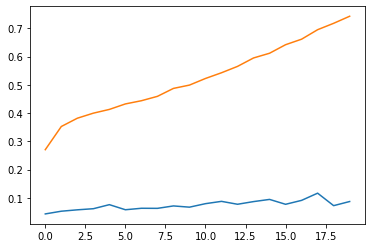

In [23]:
plt.plot(history_cat.history['val_accuracy']);
plt.plot(history_cat.history['accuracy']);

In [48]:
model.evaluate(X_test,y_test)

NameError: name 'X_test' is not defined

real age is age                                                          75
ethnicity                                                     3
gender                                                        0
img_name                         20170105180706438.jpg.chip.jpg
pixels        [205.0, 209.0, 208.0, 209.0, 211.0, 213.0, 152...
points_bin                                        (61.0, 116.0]
0                                                           0.0
1                                                           0.0
2                                                           0.0
3                                                           0.0
4                                                           0.0
5                                                           0.0
6                                                           0.0
7                                                           0.0
8                                                           0.0
9                           

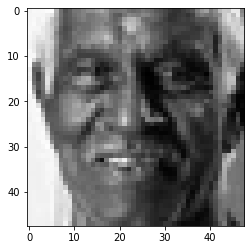

In [52]:
n=22446
plt.imshow(X[n], cmap='gray');
#np.where(y.iloc[n]==1)[0]
print(f"real age is {data.iloc[n]}")

In [53]:
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp).max()
index = np.where(model.predict(try_inp)==(model.predict(try_inp).max()))
index[1][0]

4

In [27]:
try_inp = np.expand_dims(X[n], axis=0)
model.predict(try_inp).max()
index = np.where(model.predict(try_inp)==(model.predict(try_inp).max()))
print(f'slot number {index[1][0]}, correspond to range {index[1][0]*step_size-step_size} to {index[1][0]*step_size}')

NameError: name 'step_size' is not defined

# best results using colab with regression on virgen data

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/age_gender.csv')

data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']


def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

model = initialize_model()
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

history = model.fit(X_train, y_train, epochs=100, callbacks=[es])

plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

n=5
out = np.reshape(X_test[n], (48, 48))
plt.imshow(out, cmap='gray');
y_test.iloc[n]

try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]